In [1]:
import pandas as pd
from datetime import datetime
from pathlib import Path

In [2]:
df = pd.read_excel("./data/serie_ingresos.xlsx")

In [59]:
# Filtrar columnas que contienen "Precio Monómico"
precio_cols = [col for col in df.columns if "Precio Monómico" in col]
# Seleccionar solo esas columnas (+ columnas identificativas si lo deseas)
df_precios = df[["AGENTE", "EMPRESA"] + precio_cols]  # Opción con identificadores
df_precios.to_excel("./preprocess/serie_precios_monomico.xlsx", index=False)

In [4]:
# Identificar columnas de precios que empiezan con 'Precio Monómico USD/MWh'
precio_cols = [col for col in df.columns if col.startswith("Precio Monómico")]

# Transformar a formato largo
df_long = df.melt(
    id_vars=["AGENTE", "EMPRESA"],
    value_vars=precio_cols,
    var_name="MES",
    value_name="PRECIO_MONOMICO"
)
# Limpiar columna de fecha: extraer el mes y año del nombre de columna
df_long["MES"] = df_long["MES"].str.extract(r"(\d{6})")
df_long["FECHA"] = pd.to_datetime(df_long["MES"], format="%m%Y")

# Ordenar
df_long = df_long.sort_values(["AGENTE", "FECHA"]).reset_index(drop=True)


In [5]:
# Paso 1: Transformar a formato largo
precio_cols = [col for col in df.columns if col.startswith("Precio Monómico")]
df_long = df.melt(
    id_vars=["AGENTE", "EMPRESA"],
    value_vars=precio_cols,
    var_name="MES",
    value_name="PRECIO_MONOMICO"
)

# Extraer mes y año en formato MMYYYY y convertir a fecha
df_long["MES"] = df_long["MES"].str.extract(r"(\d{6})")
df_long["FECHA"] = pd.to_datetime(df_long["MES"], format="%m%Y", errors="coerce")

# Eliminar filas sin fecha o sin valor numérico
df_long = df_long.dropna(subset=["FECHA", "PRECIO_MONOMICO"])

# Paso 2: Detección de outliers con el método IQR
Q1 = df_long["PRECIO_MONOMICO"].quantile(0.25)
Q3 = df_long["PRECIO_MONOMICO"].quantile(0.75)
IQR = Q3 - Q1

# Definir umbrales
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = df_long[(df_long["PRECIO_MONOMICO"] < lower_bound) | (df_long["PRECIO_MONOMICO"] > upper_bound)]

In [6]:
# Crear una serie temporal sin outliers
df_sin_outliers = df_long[
    (df_long["PRECIO_MONOMICO"] >= lower_bound) &
    (df_long["PRECIO_MONOMICO"] <= upper_bound)
].copy()

# Verificamos dimensiones antes y después
original_shape = df_long.shape
filtered_shape = df_sin_outliers.shape

original_shape, filtered_shape

((2194, 5), (1994, 5))

In [7]:
df_long.groupby("AGENTE")["PRECIO_MONOMICO"].mean().sort_values(ascending=False).head(10)

AGENTE
Sucre - Fancesa    2336.462695
Pagador             826.456181
Arboleda            756.263459
ECEBOL Potosí       144.445275
Catavi 115          133.497343
Vinto 115            66.991659
Jeruyo               64.834801
Irpa Irpa            56.645471
Litio - Lipez        56.219653
Tazna                54.243682
Name: PRECIO_MONOMICO, dtype: float64

In [8]:
df_sin_outliers.groupby(["FECHA","AGENTE"])["PRECIO_MONOMICO"].mean().head(10)

FECHA       AGENTE             
2023-01-01  Arboleda               24.151374
            Arocagua               40.241260
            Bermejo                34.295392
            Brechas 115            33.415023
            Brechas 69             39.736842
            Bélgica                31.198138
            COBOCE                 24.533157
            Camiri - Cordillera    34.558863
            Caranavi               34.784493
            Carrasco               32.621903
Name: PRECIO_MONOMICO, dtype: float64

In [9]:
df_merge = df_long.merge(df_sin_outliers, on=["AGENTE", "FECHA"], suffixes=('_original', '_sin_outliers'))

In [10]:
df_merge.head()

,AGENTE,EMPRESA_original,MES_original,PRECIO_MONOMICO_original,FECHA,EMPRESA_sin_outliers,MES_sin_outliers,PRECIO_MONOMICO_sin_outliers
0,Arboleda,CRE,012023,24.151374,2023-01-01,CRE,012023,24.151374
1,Arocagua,ELFEC,012023,40.241260,2023-01-01,ELFEC,012023,40.241260
2,Bermejo,SETAR,012023,34.295392,2023-01-01,SETAR,012023,34.295392
3,Brechas 115,CRE,012023,33.415023,2023-01-01,CRE,012023,33.415023
4,Brechas 69,CRE,012023,39.736842,2023-01-01,CRE,012023,39.736842


In [11]:
df_merge.columns

Index(['AGENTE', 'EMPRESA_original', 'MES_original',
       'PRECIO_MONOMICO_original', 'FECHA', 'EMPRESA_sin_outliers',
       'MES_sin_outliers', 'PRECIO_MONOMICO_sin_outliers'],
      dtype='object')

In [12]:
import pandas as pd

# Subconjunto de columnas
subset = ["EMPRESA_original", "AGENTE", "FECHA", "PRECIO_MONOMICO_original", "PRECIO_MONOMICO_sin_outliers"]
df_comp = df_merge[subset].copy()
df_comp.columns = ["EMPRESA", "AGENTE", "FECHA", "PRECIO_MONOMICO_original", "PRECIO_MONOMICO_sin_outliers"]
df_comp["FECHA"] = pd.to_datetime(df_comp["FECHA"], format="%Y-%m-%d")

In [13]:
df_comp

,EMPRESA,AGENTE,FECHA,PRECIO_MONOMICO_original,PRECIO_MONOMICO_sin_outliers
0,CRE,Arboleda,2023-01-01,24.151374,24.151374
1,ELFEC,Arocagua,2023-01-01,40.241260,40.241260
2,SETAR,Bermejo,2023-01-01,34.295392,34.295392
3,CRE,Brechas 115,2023-01-01,33.415023,33.415023
4,CRE,Brechas 69,2023-01-01,39.736842,39.736842
...,...,...,...,...,...
2049,CRE,Warnes,2025-06-01,36.336398,36.336398
2050,NO REGULADOS,YLB (Contrato ENDE),2025-06-01,53.889461,53.889461
2051,SETAR,Yacuiba,2025-06-01,48.496022,48.496022
2052,CRE,Yapacaní,2025-06-01,43.037309,43.037309


In [14]:
df_comp.to_excel("./preprocess/comparacion_precios_monomico.xlsx", index=False)

In [15]:
import pandas as pd

# Cargar la comparación ya procesada
df_comp = pd.read_excel("./preprocess/comparacion_precios_monomico.xlsx")

# Asegurar que FECHA esté en formato datetime
df_comp["FECHA"] = pd.to_datetime(df_comp["FECHA"])

# Crear columna de MES en formato MMYYYY para usar como nombre de columna
df_comp["MES"] = df_comp["FECHA"].dt.strftime("%m%Y")

# Crear nombre de columna como en el archivo original
df_comp["col_name"] = "Precio Monómico USD/MWh " + df_comp["MES"]

# Pivotear usando la columna original (también puedes hacer esto para la sin outliers si prefieres)
df_pivot = df_comp.pivot_table(
    index=["AGENTE", "EMPRESA"],
    columns="col_name",
    values="PRECIO_MONOMICO_original"
).reset_index()

# Ordenar columnas para mantener orden temporal
ordered_cols = ["AGENTE", "EMPRESA"] + sorted([col for col in df_pivot.columns if col.startswith("Precio Monómico")])
df_pivot = df_pivot[ordered_cols]

# Guardar en Excel
df_pivot.to_excel("./data/precios_monomico.xlsx", index=False)


In [17]:
df = pd.read_excel("./data/precios_monomico.xlsx")

In [18]:
df.head()  # Mostrar las primeras filas del DataFrame para verificar los cambios

,AGENTE,EMPRESA,Precio Monómico USD/MWh 012023,Precio Monómico USD/MWh 012024,Precio Monómico USD/MWh 012025,Precio Monómico USD/MWh 022023,Precio Monómico USD/MWh 022024,Precio Monómico USD/MWh 022025,Precio Monómico USD/MWh 032023,Precio Monómico USD/MWh 032024,...,Precio Monómico USD/MWh 082023,Precio Monómico USD/MWh 082024,Precio Monómico USD/MWh 092023,Precio Monómico USD/MWh 092024,Precio Monómico USD/MWh 102023,Precio Monómico USD/MWh 102024,Precio Monómico USD/MWh 112023,Precio Monómico USD/MWh 112024,Precio Monómico USD/MWh 122023,Precio Monómico USD/MWh 122024
0,Arboleda,CRE,24.151374,NaN,NaN,24.515110,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,52.550207,25.529214,24.438880,NaN,23.290439
1,Arocagua,ELFEC,40.241260,31.933846,28.553809,40.537183,30.438691,32.558565,39.480814,28.807151,...,32.581048,32.864211,32.196442,37.038228,31.994577,37.290057,33.757728,32.597750,29.739190,31.002381
2,Bermejo,SETAR,34.295392,33.004925,31.879972,37.406315,32.825683,32.040787,34.122813,32.346970,...,43.994555,41.664514,40.798887,41.447918,38.029118,45.161188,37.095425,36.742251,34.183999,35.376075
3,Brechas,CRE,NaN,34.573180,48.457389,NaN,32.673990,52.038536,NaN,29.491140,...,NaN,35.373924,35.353464,38.254852,33.853311,42.504397,35.580356,47.429671,33.131354,48.383373
4,Brechas 115,CRE,33.415023,29.970235,NaN,34.635341,31.134427,NaN,32.176612,NaN,...,36.201372,NaN,35.927090,NaN,35.160657,NaN,34.197756,NaN,29.710898,NaN


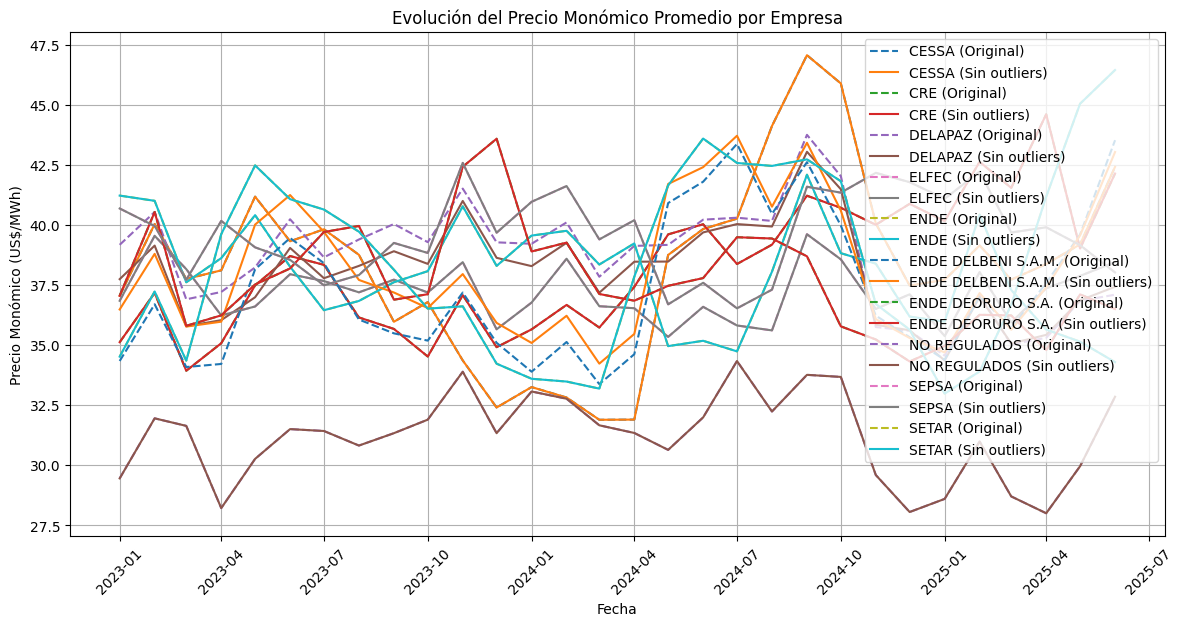

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar el archivo Excel
ruta_archivo = "./preprocess/comparacion_precios_monomico.xlsx"
df = pd.read_excel(ruta_archivo)

# 2. Asegurar que la columna FECHA esté en formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# 3. Calcular el promedio mensual de precios por EMPRESA
# Agrupamos por empresa y fecha
df_grouped = df.groupby(['EMPRESA', 'FECHA']).agg({
    'PRECIO_MONOMICO_original': 'mean',
    'PRECIO_MONOMICO_sin_outliers': 'mean'
}).reset_index()

# 4. Graficar evolución temporal de precios por empresa
empresas = df_grouped['EMPRESA'].unique()

plt.figure(figsize=(12, 6))

for empresa in empresas:
    df_empresa = df_grouped[df_grouped['EMPRESA'] == empresa]
    plt.plot(df_empresa['FECHA'], df_empresa['PRECIO_MONOMICO_original'], label=f"{empresa} (Original)", linestyle='--')
    plt.plot(df_empresa['FECHA'], df_empresa['PRECIO_MONOMICO_sin_outliers'], label=f"{empresa} (Sin outliers)", linestyle='-')

plt.title("Evolución del Precio Monómico Promedio por Empresa")
plt.xlabel("Fecha")
plt.ylabel("Precio Monómico (US$/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [20]:
df_sin_outliers.to_excel("./data/serie_precios_sin_outliers.xlsx", index=False)

In [22]:
df_sin_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1994 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   AGENTE           1994 non-null   object        
 1   EMPRESA          1994 non-null   object        
 2   MES              1994 non-null   object        
 3   PRECIO_MONOMICO  1994 non-null   float64       
 4   FECHA            1994 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 93.5+ KB
